# GenAI Workshop
## Lesson 5: RAG Evaluation & Optimization

This lesson is intended to show you how different RAG configurations affect the output quality of a Retrieval Augmented Generation system.

During this lesson you will learn how to ...

- evaluate the quality of a RAG system using simple quality metrics
- manipulate the *chunk size* and *top_k* to improve the system


### Set up the environment

In [1]:
import os
import google.generativeai as genai

if os.getenv("COLAB_RELEASE_TAG"):
   COLAB = True
   print("Running on COLAB environment.")
else:
   COLAB = False
   print("WARNING: Running on LOCAL environment.")


In [ ]:
# Clone the data repository into colab
!git clone https://github.com/openknowledge/workshop-genai-data.git
PROCESSED_DATA_PATH = "/content/workshop-genai-data/processed/gutenberg/"
EVALUATION_DATA_PATH = "/content/workshop-genai-data/evaluation/"

In [3]:
# Read and set GOOGLE_API_KEY depending of environment

if COLAB:
  # Note: GEMINI_API_KEY must be set as COLAB userdata before
  print("Initialize COLAB environment")
  from google.colab import userdata
  GOOGLE_API_KEY=userdata.get('GEMINI_API_KEY')
else:
  # GEMINI_API_KEY must be set as environment variable, e.g. inside an .env file.
  print("Initialize LOCAL environment")
  from dotenv import load_dotenv, find_dotenv
  load_dotenv(find_dotenv())
  GOOGLE_API_KEY = os.getenv("GEMINI_API_KEY")

Initialize LOCAL environment


In [4]:
# Initialize Google GenAI Client with GOOGLE_API_KEY to be able to call the model.
genai.configure(api_key=GOOGLE_API_KEY)

In [ ]:
# Install additional libraries
%%capture
!pip install -qU langchain-text-splitters chromadb

In [6]:
# Import additional libraries
from langchain_text_splitters import RecursiveCharacterTextSplitter
from chromadb import EphemeralClient
import uuid
from pydantic import BaseModel
import pandas as pd

In [7]:
# Configure pandas display options
pd.set_option("max_colwidth", None)

In [8]:
# Set defaults for retrieval
DEFAULT_TOP_K = 3
DEFAULT_CHUNK_OVERLAP = 100
DEFAULT_CHUNK_SIZE = 2000

In [9]:
# This will be the chromadb collection we use as a knowledge base. We do not need the in-memory EphemeralClient.
chromadb_client = EphemeralClient()

In [10]:
# For evaluation we need metadata. This function will additionally return the page number of the chunk
def do_chunk(text: str, chunk_size: int , chunk_overlap: int) -> tuple[list[str], list[int]]:
    """ Splits the text into chunks and maps them to page numbers
    Parameters
    ----------
    text : str
        The text to split
    chunk_size : int
        The size of the chunks
    chunk_overlap : int
        The overlap between the chunks
        Returns
    -------
    tuple[list[str], list[int]]
        Two lists: one with the chunks and another with the corresponding page numbers.
    """

    # Define amount of characters per page. This is an approximation
    CHARACTERS_PER_PAGE = 1800

    # Initialize the splitter
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)

    # Split the text
    chunks = splitter.split_text(text)

    # Prepare the lists
    chunk_texts = []
    page_numbers = []

    # Map chunks to page numbers
    for chunk in chunks:
        start_index = text.index(chunk)
        page_number = (start_index // CHARACTERS_PER_PAGE) + 1
        chunk_texts.append(chunk)
        page_numbers.append(page_number)

    return chunk_texts, page_numbers

In [11]:
# Helper function to get the page number of a specific string in the book text
def get_page_number(text: str, book_text: str, characters_per_page: int = 1800) -> int:
    """
    Finds the page number of a specific string in the book text.

    Parameters
    ----------
    text : str
        The string to search for.
    book_text : str
        The complete book text.
    characters_per_page : int, optional
        The approximate number of characters per page, by default 1800.

    Returns
    -------
    int
        The page number where the string is found, or -1 if not found.
    """
    # Find the starting index of the string
    start_index = book_text.find(text)

    # If the string is not found, return -1
    if start_index == -1:
        return -1

    # Calculate the page number
    page_number = (start_index // characters_per_page) + 1
    return page_number

In [12]:
# Since now we store metadata in the knowledgebase, we need to update the fetching function in order to
# return the metadata as well. We will use the pydantic library to define the chunk model.

class Metadata(BaseModel):
    """Represents the metadata of a document which is stored in the knowledgebase."""
    page: int
    book: str

class FetchedChunk(BaseModel):
    """Represents a chunk fetched from the knowledgebase."""
    chunk: str
    metadata: Metadata

# Building Block "Top-k Fetching": Get the k semantically closest chunks to the user input from the knowledgebase
def do_top_k_fetching(user_input_embedding: list[float], top_k: int) -> list[FetchedChunk]:
  """ Fetches the k semantically closest chunks to the user input from the knowledgebase

  Parameters
  ----------
  user_input_embedding : [float]
      The embedding of the user input
  top_k : int
      The number of semantically closest chunks to be fetched

  Returns
  -------
  context: [str]
      The fetched chunks
  """
  # Since we will do the fetching always only for one user_input,
  # instead of querying for multiple embeddings simultanously as allowed by the choma API,
  # we add the embeddings below to a list and return only the first document (chunk)
  chromadb_collection = chromadb_client.get_collection(name="default")

  query_result = chromadb_collection.query(
      query_embeddings=[user_input_embedding],
      n_results=top_k,
  )
  chunks = query_result["documents"][0]
  metadatas = query_result["metadatas"][0]
  
  fetched_chunks = []
  for i in range(len(chunks)):
    chunk = chunks[i]
    metadata = metadatas[i]
    fetched_chunk = FetchedChunk(chunk=chunk, metadata=Metadata(**metadata))
    fetched_chunks.append(fetched_chunk)
  return fetched_chunks

In [13]:
# RAG building blocks

# Get content of books. The content will already be cleansed.
def load_file_content(file_name: str) -> str:
  """ Loads content of a file in the local file systemby a given file name and return its content

    Parameters
    ----------
    file_name : str
        The name of the file to be loaded
    Returns
    -------
    file_content : str
        the content of the file as a string
    """
  with open(f"{PROCESSED_DATA_PATH}{file_name}", "r") as f:
    return f.read()

# Building Block "Embedding": Create multi dimensional embeddings for a given chunk.
def do_embed(chunk: str) -> list[float]:
  """ Embeds a given chunk and returns the embedding

  Parameters
  ----------
  chunk : str
      The chunk to be embedded
  Returns
  -------
  embedding: [float]
      The created embedding
  """
  return genai.embed_content(model=EMBEDDING_MODEL, content=chunk).get("embedding")

def do_batch_embed(chunks: list[str]) -> list[list[float]]:
  """ Embeds a list of chunks and returns the embeddings

  Parameters
  ----------
  chunks : [str]
      The chunks to be embedded
  Returns
  -------
  embeddings: [list[float]]
      The created embeddings
  """
  return genai.embed_content(model=EMBEDDING_MODEL, content=chunks).get("embedding")

# Building Block "Knowledgebase": Store embeddings and the corresponding content in a vectorstore
def persist_embeddings(chunks: list[str], embeddings: list[float], metadatas: list[dict])-> None:
  """ Persists the embeddings and the chunks in the knowledgebase

  Parameters
  ----------
  chunks : [str]
      The chunks to be persisted
  embeddings: [list[float]]
      The corresponding embeddings to be persisted
  metadatas: list[dict]
      The corresponding metadata to be persisted

  """
  # We need to define hhnsw:search_ef for determinstic results (see https://github.com/chroma-core/chroma/issues/2675)
  chromadb_collection = chromadb_client.get_or_create_collection(name="default", metadata={"hnsw:search_ef":50})
  # Persist the embeddings and the chunks in the knowledgebase
  ids = [str(uuid.uuid4()) for _ in chunks]
  chromadb_collection.add(ids=ids, documents=chunks, embeddings=embeddings, metadatas=metadatas)

In [14]:
# We need to update the ingestion in order to store the page number of the chunk
def do_ingestion(file_names: list[str], chunk_size: int = DEFAULT_CHUNK_SIZE, clear_knowledgebase: bool = False, verbose: bool = False) -> None:
  """ Ingests a list of files by a given file name and chunk

  Parameters
  ----------
  file_names : [str]
      The names of the files to be ingested
  chunk_size : int, optional [default: DEFAULT_CHUNK_SIZE]
      The desired chunk size
  clear_knowledgebase : bool, optional [default: False]
      Whether to clear the knowledgebase before ingesting the new files
  verbose : bool, optional [default: False]
      Whether to print details of the ingestion process or not. Defaults to False
  """

  # Check chunk_size in order to avoid running too long
  if chunk_size < 250:
    raise ValueError("chunk_size must higher than 250")
  
  if clear_knowledgebase:
    chromadb_client.delete_collection(name="default")

  # Ingest file by file
  for file_name in file_names:
    # Load prepared book content
    file_content = load_file_content(file_name)

    # Chunk the content into smaller chunks
    chunks, page_numbers = do_chunk(file_content, chunk_size=chunk_size, chunk_overlap=DEFAULT_CHUNK_OVERLAP)
    if verbose:
      print(f'Loaded {len(chunks)} chunks from {file_name}')

    # Embed the chunks
    embeddings = do_batch_embed(chunks)

    # Metadata: Create a list of dictionaries with the page number
    metadatas = [{"page": page, "book": file_name} for page in page_numbers]

    # Persist the embeddings and the chunks in the knowledgebase
    persist_embeddings(chunks, embeddings, metadatas=metadatas)

  if verbose:
    chunks_count = chromadb_client.get_collection(name="default").count()
    print(f'Added {chunks_count} chunks to the knowledgebase')

In [15]:
# We will only evaluate the retrieval, since this is the most important part of the pipeline
# In a real world scenario, we would also evaluate the generation using i.e. llm-based metrics
def do_retrieval(user_input: str, top_k: int = DEFAULT_TOP_K) -> list[FetchedChunk]:
  """ Retrieves the k semantically closest chunks to the user input from the knowledgebase

  Parameters
  ----------
  user_input : str
      The user input to be used for the retrieval
  top_k : int, optional [default: DEFAULT_TOP_K]
      The number of semantically closest chunks to be fetched
  Returns
  -------
  context: [str]
      The fetched chunks
  distances: [float]
      The corresponding distances to the user_input_embedding
  """
  # Embed the user input
  user_input_embedding = do_embed(user_input)

  # Fetch the k semantically closest chunks to the user input from the knowledgebase
  return do_top_k_fetching(user_input_embedding, top_k=top_k)

### Configure the genAI models

In [16]:
# We will only evaluate the retrieval, therefore we only need an embedding model
EMBEDDING_MODEL = "models/text-embedding-004"

### Prepare the knowledgebase

In [17]:
KNOWLEDGEBASE_CONTENT = set(['study_in_scarlett.txt'])

do_ingestion(file_names=KNOWLEDGEBASE_CONTENT)

### Ingested Metadata
For this exercise, we enhanced our knowledgebase with metadata. This metadata contains information about the chunk: the file name of the book and page number, where the chunk is from.

In [18]:
# Let's have a close look on the metadata
fetched_chunks = do_retrieval(user_input="Which number did Lucie noticed on the ceiling?")

print(f"Fetched {len(fetched_chunks)} chunks from the knowledgebase")
for chunk in fetched_chunks:
    print(f"Chunk: {chunk.chunk}")
    print(f"Metadata: {chunk.metadata}")
    print()

Fetched 3 chunks from the knowledgebase
Chunk: some message or remonstrance from Young as to his conduct, and he was not mistaken, though it came in an unlooked-for manner. Upon rising next morning he found, to his surprise, a small square of paper pinned on to the coverlet of his bed just over his chest. On it was printed, in bold straggling letters:—  “Twenty-nine days are given you for amendment, and then——”  The dash was more fear-inspiring than any threat could have been. How this warning came into his room puzzled John Ferrier sorely, for his servants slept in an outhouse, and the doors and windows had all been secured. He crumpled the paper up and said nothing to his daughter, but the incident struck a chill into his heart. The twenty-nine days were evidently the balance of the month which Young had promised. What strength or courage could avail against an enemy armed with such mysterious powers? The hand which fastened that pin might have struck him to the heart, and he could n

In [19]:
# In order to identify the origin of a chunk, we use the following concatenation of the book name and the page number
def get_origin(chunk: FetchedChunk) -> str:
    """ Returns the origin of a chunk by concatenating the book name and the page number

    Parameters
    ----------
    chunk : FetchedChunk
        The chunk to be used for the origin
    Returns
    -------
    origin: str
        The origin of the chunk
    """
    return f"{chunk.metadata.book}:{chunk.metadata.page}"

# This is the origin of a chunk
print(f"Metadata of the chunk: \t{fetched_chunks[0].metadata}")
print(f"Origin of the chunk: \t{get_origin(fetched_chunks[0])}")


Metadata of the chunk: 	page=96 book='study_in_scarlett.txt'
Origin of the chunk: 	study_in_scarlett.txt:96


### Metrics
Matching the *text of the retrieved chunk* with *the text of the ground truth chunk* introduces some challenges caused by differing chunk sizes between retrieved and ground truth chunks. Having metadata is perfect for information retrieval metrics, because we can match the *retrieved metadata* with the *ground truth metadata*. For this reason, we will use the following three metrics for matching metadata:

#### Hit Rate
Hit Rate is an information retrieval metric that measures whether at least one relevant result (*ground truth chunk*) appears in a list of search results (*retrieved chunks*). If there is at least one relevant item, the hit rate is 1; if there are none, it is 0. It simply checks for the presence of any relevant result, regardless of its position.

In [20]:
# Function to calculate the hit rate
def calculate_hit_rate(ground_truth, retrieved: list[str]) -> int:
    gt_set = set(ground_truth)
    retrieved_set = set(retrieved)
    return int(bool(gt_set & retrieved_set))

In [21]:
# Lets test Hit Rate. Try it yourself with different values
ground_truth = ["study_in_scarlett.txt:22"]
retrieved = ["study_in_scarlett.txt:22", "study_in_scarlett.txt:23"]
print(f"Hit Rate: {calculate_hit_rate(ground_truth, retrieved)}")

Hit Rate: 1


#### Reciprocal Rank
Reciprocal Rank is an information retrieval metric that measures how soon the first relevant result (*ground truth chunk*) appears in a list of search results (*retrieved chunks*). It is calculated as the inverse (1 divided by the rank) of the position of the first relevant result. For example, if the first relevant result is at position 3, the reciprocal rank is 1/3. If the retrieved chunks do not contain any ground truth chunk, the reciprocal rank is 0.

In [22]:
# Function to calculate the calculate_reciprocal_rank
def calculate_reciprocal_rank(ground_truth: list[str], retrieved: list[str]) -> float:
    gt_set = set(ground_truth)
    for rank, item in enumerate(retrieved, start=1):
        if item in gt_set:
            return 1 / rank
    return 0.0

In [23]:
# Let's test Reciprocal Rank. Try it yourself with different values
ground_truth = ["study_in_scarlett.txt:22"]
retrieved = ["adventures_of_sherlock_holmes.txt:903","study_in_scarlett.txt:22", "study_in_scarlett.txt:3"]
print(f"Reciprocal Rank: {calculate_reciprocal_rank(ground_truth, retrieved)}")

Reciprocal Rank: 0.5


#### Precision
Precision is an information retrieval metric that measures the proportion of retrieved results that are actually relevant. It is calculated as the number of relevant results divided by the total number of results returned (*top-k*). For example, if 1 out of 4 retrieved documents are relevant (present in the *ground truth*), the precision is 0.25 (25%).

In [24]:
# Function to calculate the precision
def calculate_precision(ground_truth: list[str], retrieved: list[str]) -> float:
    # Number of retrieved items
    top_k = len(retrieved)

    # Elements, which are present in both ground truth and retrieved
    relevant_items_in_retrieved = (set(ground_truth) & set(retrieved))

    return len(relevant_items_in_retrieved) / top_k

In [25]:
# Let's test Precision. Try it yourself with different values
ground_truth = ["study_in_scarlett.txt:22"]
retrieved = ["adventures_of_sherlock_holmes.txt:903","study_in_scarlett.txt:22", "study_in_scarlett.txt:3","adventures_of_sherlock_holmes.txt:10"]
print(f"Precision: {calculate_precision(ground_truth, retrieved)}")

Precision: 0.25


### Evaluation
Measure the current performance of the retrieval.

In [26]:
# Load testdata
evaluation_dataframe = pd.read_csv(EVALUATION_DATA_PATH + 'evaluation_dataset.csv')
evaluation_dataframe.head()

,question,ground_truth_origin,ground_truth_answer
0,What year does Dr. Watson complete his medical degree?,study_in_scarlett.txt:1,1878
1,Where do Sherlock Holmes and Dr. Watson decide to live together?,study_in_scarlett.txt:10,221B Baker Street
2,What word does Sherlock Holmes find written in blood on the wall at the crime scene?,study_in_scarlett.txt:30,RACHE
3,What profession does Sherlock Holmes describe himself as having?,study_in_scarlett.txt:30,A consulting detective
4,Who is the woman that Sherlock Holmes admires and refers to as 'the woman'?,adventures_of_sherlock_holmes.txt:28,Irene Adler


In [27]:
# Function to run evaluation fo specific top_k
def evaluate_retrieval(top_k: int = DEFAULT_TOP_K) -> tuple[float, float, float]:
    """ Evaluates the retrieval performance using precision, reciprocal rank and hit rate
    Parameters
    ----------
    top_k : int, optional [default: DEFAULT_TOP_K]
        The number of semantically closest chunks to be fetched
    Returns
    -------
    tuple[float, float, float]
        The precision, reciprocal rank and hit rate
    """
    # Create empty lists to store the metrics
    precisions = []
    reciprocal_ranks = []
    hit_rates = []

    for _, row in evaluation_dataframe.iterrows():
        # Get the question and the ground truth origin
        question = row['question']
        ground_truth_origin = row['ground_truth_origin']

        # Retrieve the chunks
        retrieved_chunks = do_retrieval(question, top_k=top_k)

        # Get the origins of the retrieved chunks
        retrieved_origins = [get_origin(chunk) for chunk in retrieved_chunks]

        # Calculate the metrics
        precisions.append(calculate_precision([ground_truth_origin], retrieved_origins))
        reciprocal_ranks.append(calculate_reciprocal_rank([ground_truth_origin], retrieved_origins))
        hit_rates.append(calculate_hit_rate([ground_truth_origin], retrieved_origins))
    # Calculate the average metrics
    avg_precision = sum(precisions) / len(precisions)
    avg_reciprocal_rank = sum(reciprocal_ranks) / len(reciprocal_ranks)
    avg_hit_rate = sum(hit_rates) / len(hit_rates)
    return (avg_precision, avg_reciprocal_rank, avg_hit_rate)

In [28]:
# Measure the performance of the retrieval

# Configure retrieval
top_k = 3

# Evaluate the retrieval performance
mean_precision, mean_reciprocal_rank, mean_hit_rate = evaluate_retrieval(top_k=top_k)

# Print the results
print(f"Average Precision: {mean_precision:.2f}")
print(f"Average Reciprocal Rank: {mean_reciprocal_rank:.2f}")
print(f"Average Hit Rate: {mean_hit_rate:.2f}")

Average Precision: 0.03
Average Reciprocal Rank: 0.10
Average Hit Rate: 0.10


### Ingest remaining stories

In [29]:
# Ingest the second book, which contains the other stories
KNOWLEDGEBASE_CONTENT.add('adventures_of_sherlock_holmes.txt')
do_ingestion(file_names=KNOWLEDGEBASE_CONTENT, clear_knowledgebase=False)

### Exercise 01: Evaluate RAG (again)
The initial performance of the retrieval was quite low. A possible explanation might be, that we asked the system about a book, we did not ingest. Now, that we ingested the remaining book, it is your task to measure the performance again.  
**Hint**: If you need to cancel the process, make sure that you restart the runtime and execute alle code above

In [ ]:
# TODO: Measure the performance of the retrieval with the second book

# TODO: Evaluate the retrieval performance
mean_precision, mean_reciprocal_rank, mean_hit_rate = evaluate_retrieval(top_k=top_k)

# TODO: Print the results
print(f"Average Precision: {mean_precision:.2f}")
print(f"Average Reciprocal Rank: {mean_reciprocal_rank:.2f}")
print(f"Average Hit Rate: {mean_hit_rate:.2f}")

Average Precision: 0.10
Average Reciprocal Rank: 0.30
Average Hit Rate: 0.30


### Exercise 02: Optimize RAG
Now that we know, how the retrieval performs, we should improve it. It is your task, to improve the performance by manipulating two variables: *top-k* and *chunk-size*. Keep in mind that you have to run the ingestion pipeline again, as soon as you change the *chunk size*. Try to find reasons, why the metrics increase/decrease the way they do!  
**Hint**: If you need to cancel the process, make sure that you restart the runtime and execute alle code above

In [ ]:
# TODO: Find the optimal configuration
# Be careful: Do not set the chunk_size below 250, otherwise the ingestion will take too long
chunk_size = 1000   # TODO: Set the chunk size
top_k = 3           # TODO: Set the top_k

# Ingest both books
do_ingestion(file_names=KNOWLEDGEBASE_CONTENT, chunk_size=chunk_size, clear_knowledgebase=True)

# Evaluate the retrieval performance
mean_precision, mean_reciprocal_rank, mean_hit_rate = evaluate_retrieval(top_k=top_k)

# Print the results
print(f"Average Precision: {mean_precision:.2f}")
print(f"Average Reciprocal Rank: {mean_reciprocal_rank:.2f}")
print(f"Average Hit Rate: {mean_hit_rate:.2f}")

Average Precision: 0.17
Average Reciprocal Rank: 0.33
Average Hit Rate: 0.50


### Learnings
* Increasing the chunk size can lead to better performance
* At some point the high chunk size leads to bad performance in the retrieval, since the semantic meaning vanishes
* Increasing top-k increases Hit Rate, but decreases Precision. This will be a problem, when we do the generation step in addition (too much unimportant context for the model)
* Reciprocal Rank increases a little, if we increase top-k, since we now find the right chunks (but at a very bad rank)


In [ ]:
# This will take approx. 2-3 minutes
mean_hit_rates = []
mean_precisions = []
mean_reciprocal_ranks = []
chunk_sizes_all = []
top_ks_all = []

chunk_sizes = [500, 1000, 2000, 5000]
top_ks = [1, 3, 5, 10]

for chunk_size in chunk_sizes:
    # Ingest both books
    do_ingestion(file_names=KNOWLEDGEBASE_CONTENT, chunk_size=chunk_size, clear_knowledgebase=True)

    for top_k in top_ks:
        # Evaluate the retrieval performance
        mean_precision, mean_reciprocal_rank, mean_hit_rate = evaluate_retrieval(top_k=top_k)
        
        # Append the results to the lists
        mean_hit_rates.append(mean_hit_rate)
        mean_precisions.append(mean_precision)
        mean_reciprocal_ranks.append(mean_reciprocal_rank)
        chunk_sizes_all.append(chunk_size)
        top_ks_all.append(top_k)

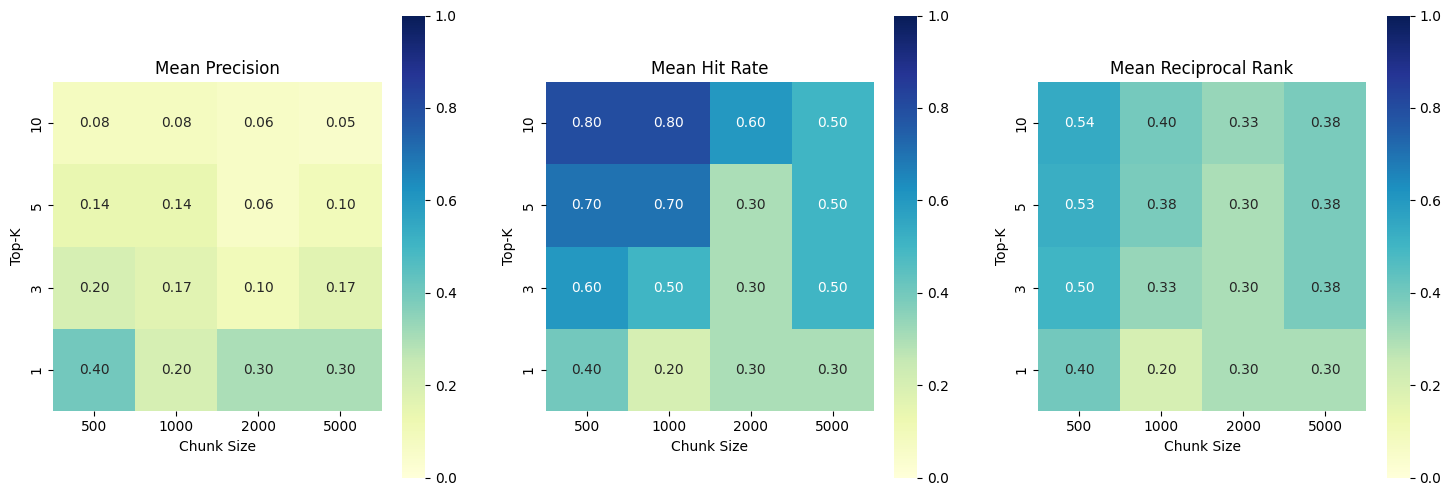

In [33]:
# Visualize the results
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Prepare the data for visualization
data = pd.DataFrame({
    'chunk_size': chunk_sizes_all,
    'top_k': top_ks_all,
    'mean_precision': mean_precisions,
    'mean_hit_rate': mean_hit_rates,
    'mean_reciprocal_rank': mean_reciprocal_ranks
})

# Plot Results
plt.figure(figsize=(18, 6))
plt. subplot(1, 3, 1)
heatmap_data_precision = data.pivot(index='top_k', columns='chunk_size', values='mean_precision')
sns.heatmap(heatmap_data_precision, annot=True, cmap="YlGnBu", fmt=".2f", vmin=0, vmax=1, square=True)
plt.title('Mean Precision')
plt.xlabel('Chunk Size')
plt.ylabel('Top-K')
plt.gca().invert_yaxis()

plt. subplot(1, 3, 2)
heatmap_data_hit_rate = data.pivot(index='top_k', columns='chunk_size', values='mean_hit_rate')
sns.heatmap(heatmap_data_hit_rate, annot=True, cmap="YlGnBu", fmt=".2f", vmin=0, vmax=1, square=True)
plt.title('Mean Hit Rate')
plt.xlabel('Chunk Size')
plt.ylabel('Top-K')
plt.gca().invert_yaxis()

plt. subplot(1, 3, 3)
heatmap_data_mrr = data.pivot(index='top_k', columns='chunk_size', values='mean_reciprocal_rank')
sns.heatmap(heatmap_data_mrr, annot=True, cmap="YlGnBu", fmt=".2f", vmin=0, vmax=1, square=True)
plt.title('Mean Reciprocal Rank')
plt.xlabel('Chunk Size')
plt.ylabel('Top-K')
plt.gca().invert_yaxis()

plt.show()